In [1]:
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=pd.errors.ParserWarning)

import matplotlib.pyplot as plt
import seaborn as sns

### 1 Read data

In [2]:
occupations = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

age_groups = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}

In [3]:
basic_path_to_dataset = "../../data/ml-1m/"

# read ratings
filename = "ratings.dat"
df_ratings = pd.read_csv(basic_path_to_dataset+filename, header=None, sep="::")
df_ratings.columns = ["UserID", "MovieID", "Rating", "Timestamp"]

# read users
filename = "users.dat"
df_users = pd.read_csv(basic_path_to_dataset+filename, header=None, sep="::")
df_users.columns = ["UserID", "Gender", "Age", "Occupation", "Zip-Code"]

# read movies
filename = "movies.dat"
df_movies = pd.read_csv(basic_path_to_dataset+filename, header=None, sep="::")
df_movies.columns = ["MovieID", "Title", "Genres"]

In [4]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-Code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
df_movies["Genres"] = df_movies["Genres"].apply(lambda x: x.split('|'))
df_movies["Year"] = df_movies["Title"].apply(lambda x: re.search(r'\((\d{4})\)', x)[1]).astype(int)
df_movies["Title"] = df_movies["Title"].apply(lambda x: re.sub(r'\s*\(\d{4}\)\s*$', '', x))
df_movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


### 2 Exploratory data analysis

### 2.1 Movies

In [7]:
df_movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


General stats about movies:

In [8]:
df_movies["Year"].describe().astype(int)

count    3883
mean     1986
std        16
min      1919
25%      1982
50%      1994
75%      1997
max      2000
Name: Year, dtype: int64

Genres distribution:

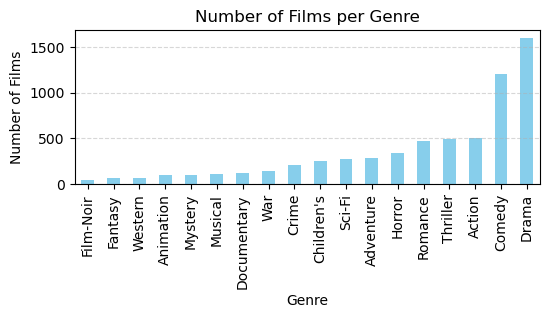

In [9]:
genre_counts = df_movies.explode('Genres')["Genres"].value_counts().sort_values()

plt.figure(figsize=(6, 2)) 
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Films per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Films')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

The years films were released:

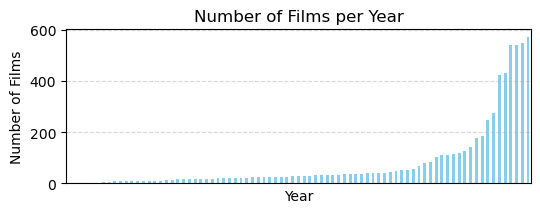

In [10]:
genre_counts = df_movies.explode('Genres')["Year"].value_counts(ascending=True)

plt.figure(figsize=(6, 2)) 
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.xticks(rotation=90)
plt.xticks([])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

The years films were released (by genres):

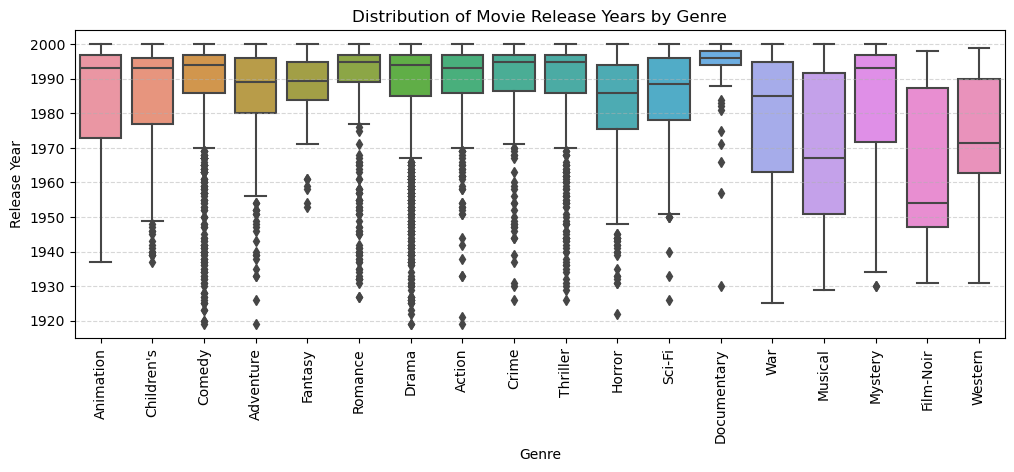

In [11]:
df_exploded = df_movies.explode('Genres')
plt.figure(figsize=(12, 4))
sns.boxplot(x='Genres', y='Year', data=df_exploded)
plt.title('Distribution of Movie Release Years by Genre')
plt.xlabel('Genre')
plt.ylabel('Release Year')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

Preparing dummy variables:

In [12]:
one_hot_df = pd.get_dummies(df_movies["Genres"].explode())
one_hot_df = one_hot_df.groupby(one_hot_df.index).sum()
one_hot_df.head(1)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# save data
# df_movies_onehot = pd.concat([df_movies, one_hot_df], axis=1, join="inner")
# df_movies_onehot.to_pickle("../../data/ml-1m-prepared/movies.pickle")

### 2.2 Users

In [14]:
df_users.head(3)

,UserID,Gender,Age,Occupation,Zip-Code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


Mode of users features:

In [15]:
df_users[["Gender", "Age", "Occupation"]].mode(axis=0)

,Gender,Age,Occupation
0,M,25,4


Genders distribution:

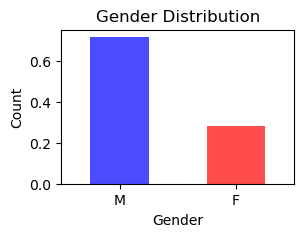

In [16]:
plt.figure(figsize=(3, 2))
df_users['Gender'].value_counts(normalize=True).plot(kind='bar',
                                                     color=['blue', 'red'],
                                                     alpha=0.7)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Occupation distribution:

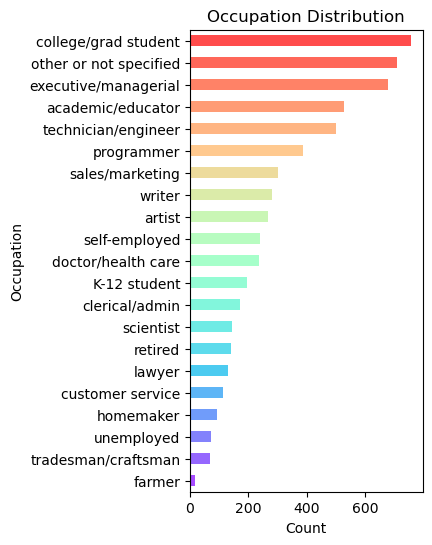

In [17]:
plt.figure(figsize=(3, 6))
occupation_counts = df_users["Occupation"].map(occupations).value_counts(normalize=False).sort_values(ascending=True)
colors = plt.cm.rainbow(np.linspace(0, 1, len(occupation_counts)))
occupation_counts.plot(kind='barh', alpha=0.7, color=colors)
plt.title('Occupation Distribution')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.xticks(rotation=0)
plt.show()

Age distribution:

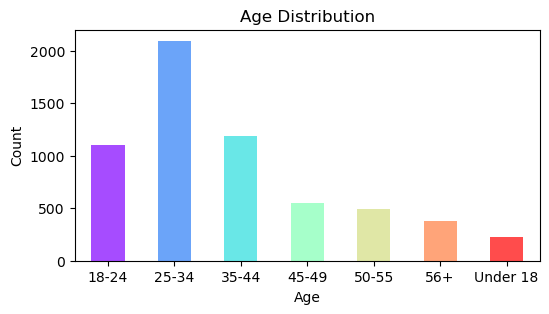

In [18]:
plt.figure(figsize=(6, 3))
occupation_counts = df_users["Age"].map(age_groups).value_counts(normalize=False).sort_index(ascending=True)
colors = plt.cm.rainbow(np.linspace(0, 1, len(occupation_counts)))
occupation_counts.plot(kind='bar', alpha=0.7, color=colors)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Process ZIP and add states:

In [19]:
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()

def get_location_info(zip_code):
    try:
        result = zcdb[zip_code]
        return result.state, result.latitude, result.longitude
    except:
        return None, None, None
    
df_users[['State', 'Latitude', 'Longitude']] = df_users['Zip-Code'].apply(lambda x: pd.Series(get_location_info(x)))

In [20]:
df_users.head(1)

,UserID,Gender,Age,Occupation,Zip-Code,State,Latitude,Longitude
0,1,F,1,10,48067,MI,42.488735,-83.13752


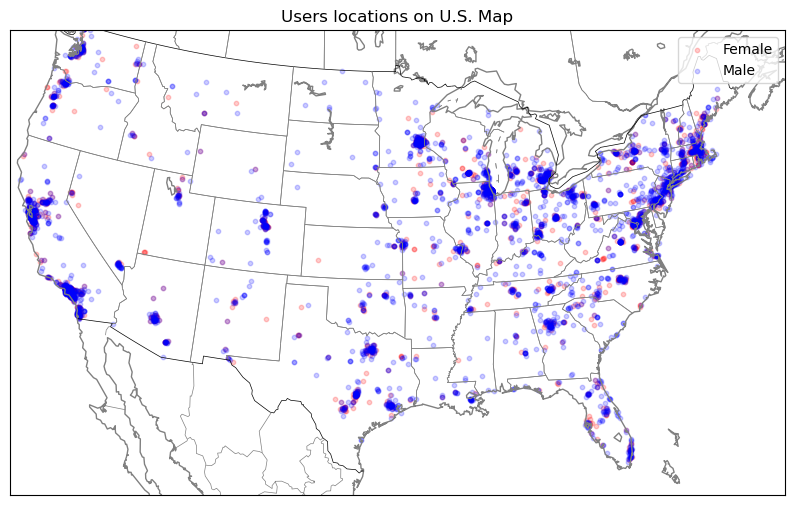

In [21]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(10, 8))
m = Basemap(projection='lcc', resolution='l',
            lat_0=38, lon_0=-95,  # Central coordinates
            width=5E6, height=3E6)  # Adjusted dimensions for better coverage

m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='gray')

# create subsets
df_female = df_users[df_users['Gender'] == 'F']
df_male = df_users[df_users['Gender'] == 'M']

# plot data points
for df, color, sex in zip([df_female, df_male],
                          ['red', 'blue'], ['Female', 'Male']):
    x, y = m(df['Longitude'].values, df['Latitude'].values)
    m.scatter(x, y, color=color, marker='o',
            s=10, alpha=0.2, label=sex)

plt.legend(loc='best')
plt.title('Users locations on U.S. Map')
plt.show()

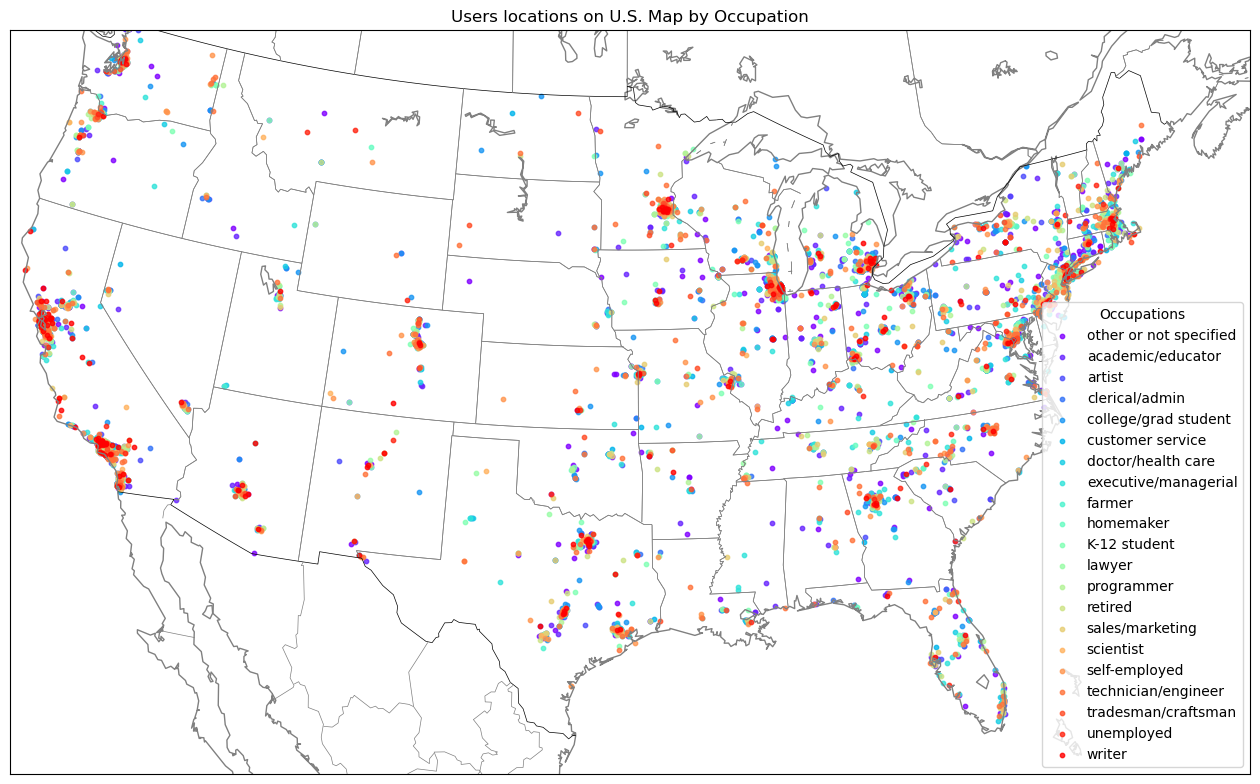

In [22]:
plt.figure(figsize=(16, 12))
m = Basemap(projection='lcc', resolution='l',
            lat_0=38, lon_0=-95,  # Central coordinates
            width=5E6, height=3E6)

m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='gray')

colors = plt.cm.rainbow(np.linspace(0, 1, len(occupations)))
for (occupation, group), color in zip(df_users.groupby('Occupation'), colors):
    x, y = m(group['Longitude'].values, group['Latitude'].values)
    m.scatter(x, y, color=color, marker='o', s=10, alpha=0.8, label=occupations[occupation])

plt.legend(loc='best', title="Occupations")
plt.title('Users locations on U.S. Map by Occupation')
plt.show()

Number of users per state:

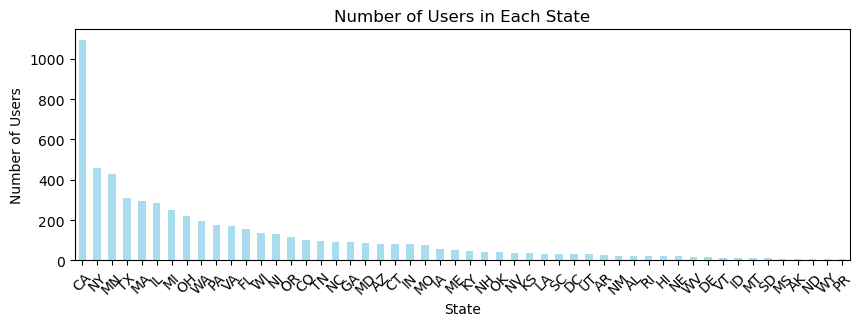

In [23]:
# Plot the number of users in each state
state_counts = df_users['State'].value_counts()

plt.figure(figsize=(10, 3))
state_counts.plot(kind='bar', alpha=0.7, color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each State')
plt.show()

In [24]:
# save data
# df_users.to_pickle("../../data/ml-1m-prepared/users.pickle")

### 2.3 Ratings

In [25]:
df_ratings.head(3)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


#### 2.3.1 Process time

In [26]:
df_ratings["Datetime"] = pd.to_datetime(df_ratings['Timestamp'], unit='s')
df_ratings["Date"] = df_ratings["Datetime"].dt.date
df_ratings.head(3)

,UserID,MovieID,Rating,Timestamp,Datetime,Date
0,1,1193,5,978300760,2000-12-31 22:12:40,2000-12-31
1,1,661,3,978302109,2000-12-31 22:35:09,2000-12-31
2,1,914,3,978301968,2000-12-31 22:32:48,2000-12-31


Ratings distributions over time:

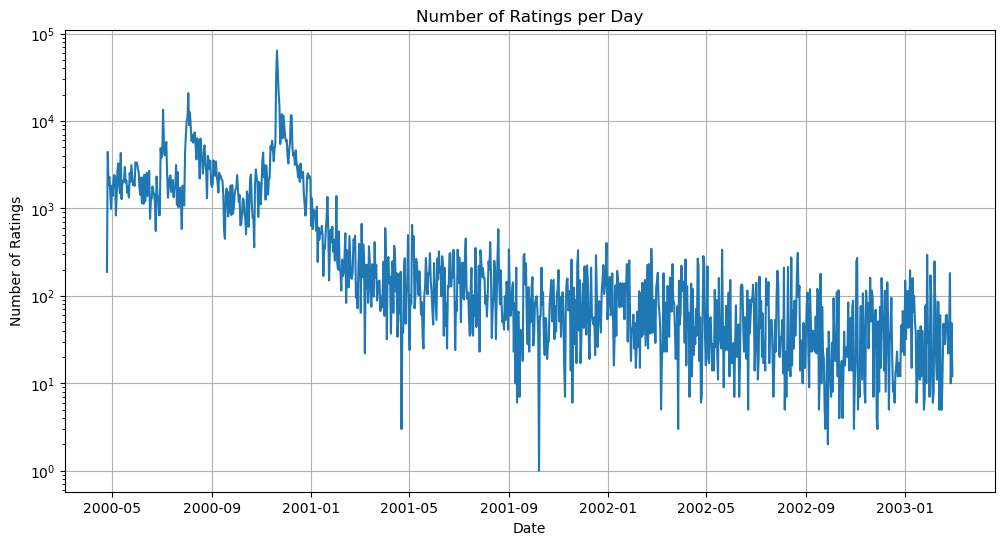

In [27]:
ratings_per_day = df_ratings.groupby('Date').size().sort_index()

plt.figure(figsize=(12, 6))
ratings_per_day.plot(kind='line', logy=True)
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Day')
plt.grid(True)
plt.show()

Most "popular day":

In [28]:
top_day = list(ratings_per_day.sort_values(ascending=False).index)[0]
top_day

datetime.date(2000, 11, 20)

Check number of movies ratings in outlier day (nothing strange): 

In [29]:
df_ratings[df_ratings["Date"]==top_day].groupby("MovieID").count().sort_values("Rating", ascending=False)

,UserID,Rating,Timestamp,Datetime,Date
MovieID,,,,,
2858,335,335,335,335,335
589,255,255,255,255,255
480,245,245,245,245,245
110,239,239,239,239,239
1196,231,231,231,231,231
...,...,...,...,...,...
3132,1,1,1,1,1
1202,1,1,1,1,1
3118,1,1,1,1,1


Check number of ratings by users in outlier day. Mean for top 100 reviewers: 

In [30]:
df_ratings[df_ratings["Date"]==top_day].groupby("UserID").count().sort_values("Rating", ascending=False).iloc[:100].mean()["Rating"]

306.75

In [31]:
df_ratings[df_ratings["Date"]==top_day].groupby("UserID").count().sort_values("Rating", ascending=False).iloc[:5]["Rating"]

UserID
1680    884
1613    779
1632    768
1741    660
1764    612
Name: Rating, dtype: int64

#### 2.3.2 Process movies

Average rating and number of votes:

In [32]:
rating_stats = df_ratings.groupby("MovieID")["Rating"].agg(["mean", "count"]).reset_index()
rating_stats

,MovieID,mean,count
0,1,4.146846,2077
1,2,3.201141,701
2,3,3.016736,478
3,4,2.729412,170
4,5,3.006757,296
...,...,...,...
3701,3948,3.635731,862
3702,3949,4.115132,304
3703,3950,3.666667,54
3704,3951,3.900000,40


In [33]:
movies_with_ratings = rating_stats.merge(df_movies, on="MovieID")
movies_with_ratings.shape
movies_with_ratings.head(1)

,MovieID,mean,count,Title,Genres,Year
0,1,4.146846,2077,Toy Story,"[Animation, Children's, Comedy]",1995


Movies rating distribution:

Text(0, 0.5, 'Count')

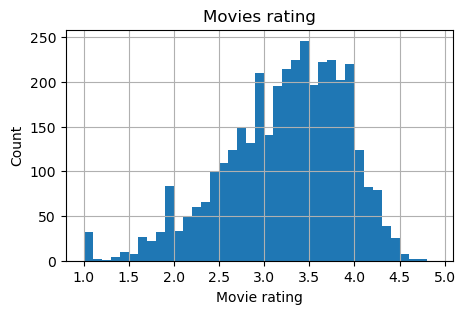

In [34]:
plt.figure(figsize=(5, 3))
movies_with_ratings["mean"].hist(bins=np.arange(1, 5, 0.1))
plt.title("Movies rating")
plt.xlabel("Movie rating")
plt.ylabel("Count")

Movies popularity distribution:

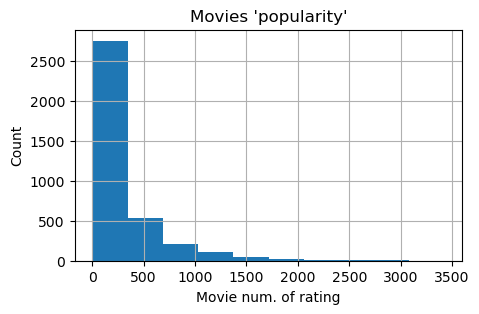

In [35]:
plt.figure(figsize=(5, 3))
movies_with_ratings["count"].hist()
plt.title("Movies 'popularity'")
plt.xlabel("Movie num. of rating")
plt.ylabel("Count")
plt.show()

How much movies have more than 10 reviews? (83%)

In [36]:
movies_with_ratings = movies_with_ratings[movies_with_ratings["count"]>10]
movies_with_ratings.shape[0] / df_movies.shape[0]

0.8326036569662632

Top movies by rating:

In [37]:
display(movies_with_ratings.sort_values("mean", ascending=False)[:5])

,MovieID,mean,count,Title,Genres,Year
2698,2905,4.608696,69,Sanjuro,"[Action, Adventure]",1962
1839,2019,4.560510,628,Seven Samurai (The Magnificent Seven) (Shichin...,"[Action, Drama]",1954
309,318,4.554558,2227,"Shawshank Redemption, The",[Drama],1994
802,858,4.524966,2223,"Godfather, The","[Action, Crime, Drama]",1972
708,745,4.520548,657,"Close Shave, A","[Animation, Comedy, Thriller]",1995


Top movies by popularity:

In [38]:
display(movies_with_ratings.sort_values("count", ascending=False)[:5])

,MovieID,mean,count,Title,Genres,Year
2651,2858,4.317386,3428,American Beauty,"[Comedy, Drama]",1999
253,260,4.453694,2991,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977
1106,1196,4.292977,2990,Star Wars: Episode V - The Empire Strikes Back,"[Action, Adventure, Drama, Sci-Fi, War]",1980
1120,1210,4.022893,2883,Star Wars: Episode VI - Return of the Jedi,"[Action, Adventure, Romance, Sci-Fi, War]",1983
466,480,3.763847,2672,Jurassic Park,"[Action, Adventure, Sci-Fi]",1993


#### 2.3.3 Process Users:

In [39]:
rating_stats = df_ratings.groupby("UserID")["Rating"].agg(["mean", "count", "std"]).reset_index()

Average rating by user:

In [40]:
print(round(rating_stats["mean"].mean(), 2))

3.7


Average rating by user distribution:

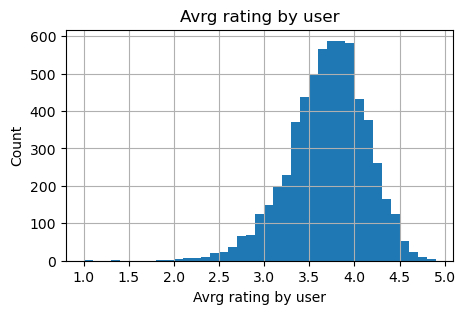

In [41]:
plt.figure(figsize=(5, 3))
rating_stats["mean"].hist(bins=np.arange(1, 5, 0.1))
plt.title("Avrg rating by user")
plt.xlabel("Avrg rating by user")
plt.ylabel("Count")
plt.show()

Suspicious user and user with "low information" will have low STD:

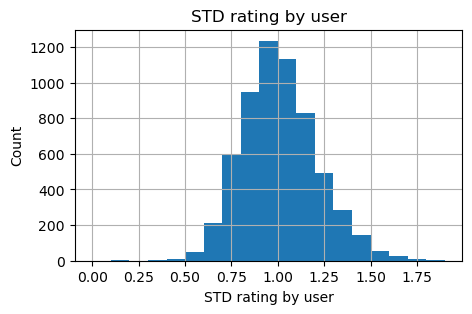

In [42]:
plt.figure(figsize=(5, 3))
rating_stats["std"].hist(bins=np.arange(0, 2, 0.1))
plt.title("STD rating by user")
plt.xlabel("STD rating by user")
plt.ylabel("Count")
plt.show()

Number of ratings by user:

In [43]:
print(f"Mean: {round(rating_stats['count'].mean(), 1)}")
print(f"Mode: {round(rating_stats['count'].mode().iloc[0])}")

Mean: 165.6
Mode: 21


Number of ratings by user, distribution:

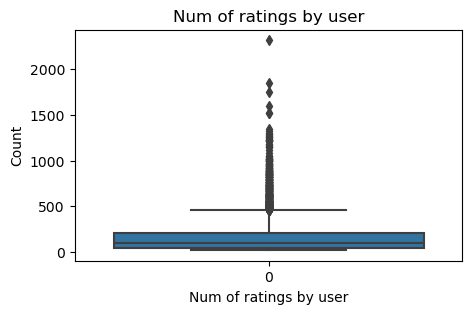

In [44]:
plt.figure(figsize=(5, 3))
sns.boxplot(rating_stats["count"])
plt.title("Num of ratings by user")
plt.xlabel("Num of ratings by user")
plt.ylabel("Count")
plt.show()

Strange users:

In [45]:
display(rating_stats.sort_values("mean").iloc[:3])
display(rating_stats.sort_values("mean").iloc[-3:])

,UserID,mean,count,std
3597,3598,1.015385,65,0.124035
4485,4486,1.058824,51,0.310597
2743,2744,1.304348,138,1.050608


,UserID,mean,count,std
3323,3324,4.904762,21,0.436436
2338,2339,4.956522,23,0.208514
282,283,4.962963,27,0.192450


In [46]:
df_users[df_users['UserID']==3598]

,UserID,Gender,Age,Occupation,Zip-Code,State,Latitude,Longitude
3597,3598,M,56,1,90210,CA,34.088808,-118.40612


In [47]:
# save data
# df_ratings.to_pickle("../../data/ml-1m-prepared/ratings.pickle")

#### 2.4 Additional EDA:

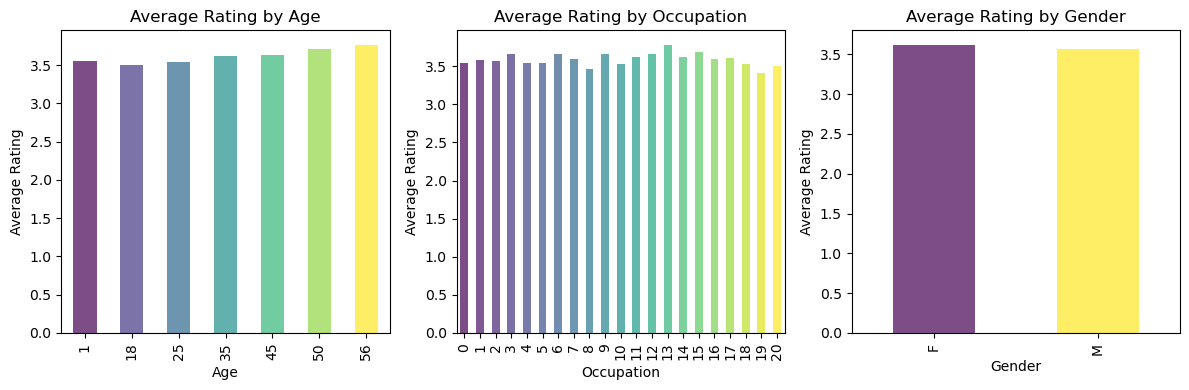

In [48]:
df_merged = pd.merge(df_ratings, df_users, on='UserID')

avg_rating_by_age = df_merged.groupby('Age')['Rating'].mean()
avg_rating_by_occupation = df_merged.groupby('Occupation')['Rating'].mean()
avg_rating_by_gender = df_merged.groupby('Gender')['Rating'].mean()

# average ratings by age
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(avg_rating_by_age)))
avg_rating_by_age.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Average Rating by Age')
plt.xlabel('Age')
plt.ylabel('Average Rating')

# average ratings by occupation
plt.subplot(1, 3, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(avg_rating_by_occupation)))
avg_rating_by_occupation.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Average Rating by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Rating')

# average ratings by gender
plt.subplot(1, 3, 3)
colors = plt.cm.viridis(np.linspace(0, 1, len(avg_rating_by_gender)))
avg_rating_by_gender.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Average Rating by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Rating')

plt.tight_layout()
plt.show()

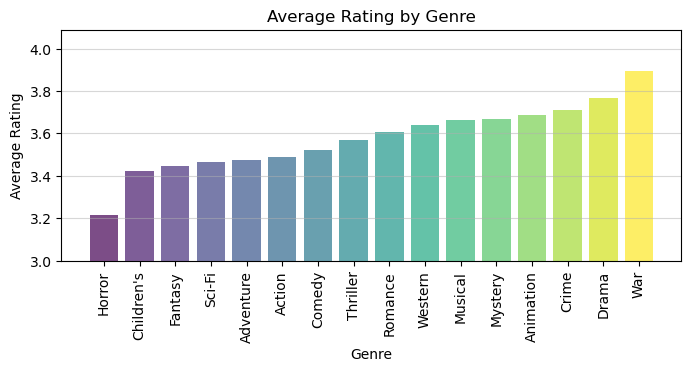

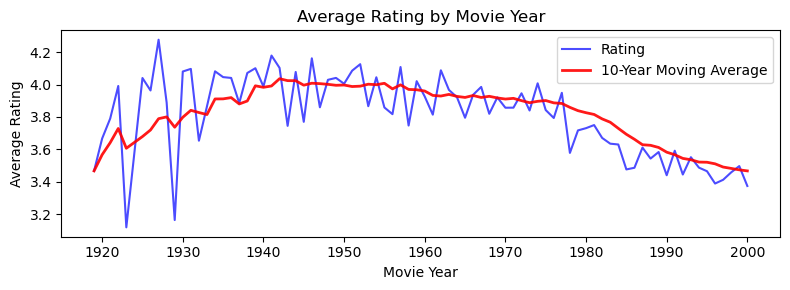

In [49]:
df_merged = pd.merge(df_ratings, df_movies, on='MovieID')

# Calculate average rating by genre
genre_ratings = {}
for genre in ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']:
    df_merged[genre] = df_merged['Genres'].apply(lambda x: genre in x)
    genre_ratings[genre] = df_merged[df_merged[genre]]['Rating'].mean()
genre_ratings = dict(sorted(genre_ratings.items(), key=lambda item: item[1]))

avg_rating_by_year = df_merged.groupby('Year')['Rating'].mean().sort_index(ascending=True)
moving_avg_rating_by_year = avg_rating_by_year.rolling(window=10, min_periods=1).mean()


# average ratings by genre
plt.figure(figsize=(8, 3))
colors = plt.cm.viridis(np.linspace(0, 1, len(genre_ratings)))
plt.bar(genre_ratings.keys(), genre_ratings.values(), color=colors, alpha=0.7)
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.grid(axis='y', alpha=0.5)
plt.ylim(3)
plt.ylabel('Average Rating')
plt.xticks(rotation=90)

# average ratings by movie age
plt.figure(figsize=(8, 3))
avg_rating_by_year.plot(kind='line', color='blue', alpha=0.7)
moving_avg_rating_by_year.plot(kind='line', color='red', alpha=0.9, linewidth=2, label='10-Year Moving Average')
plt.title('Average Rating by Movie Year')
plt.xlabel('Movie Year')
plt.legend()
plt.ylabel('Average Rating')

plt.tight_layout()
plt.show()

#### 2.5 How to split data?

After 2001-1 all users have at leat one review:

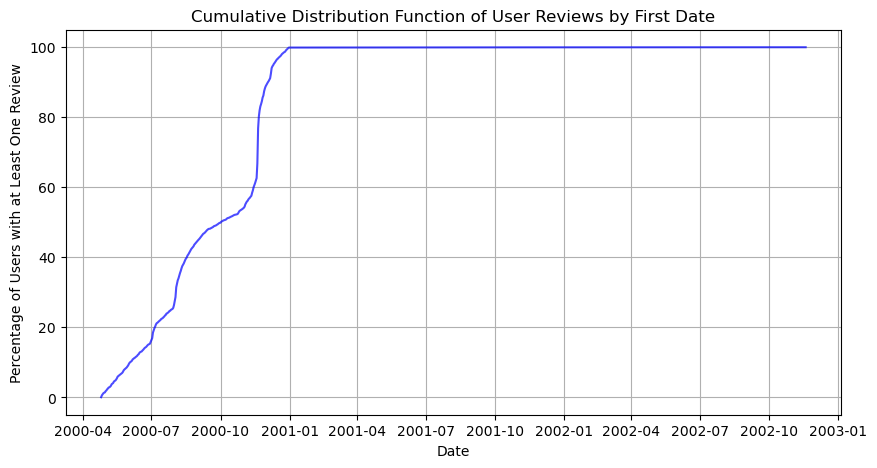

In [98]:
first_review_dates = df_ratings.groupby("UserID")["Date"].min()

# cumulative distribution
cdf_data = first_review_dates.value_counts().sort_index().cumsum()
cdf_data = cdf_data / cdf_data.max() * 100 

plt.figure(figsize=(10, 5))
plt.plot(cdf_data.index, cdf_data.values, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of User Reviews by First Date')
plt.xlabel('Date')
plt.ylabel('Percentage of Users with at Least One Review')
plt.grid(True)
plt.show()

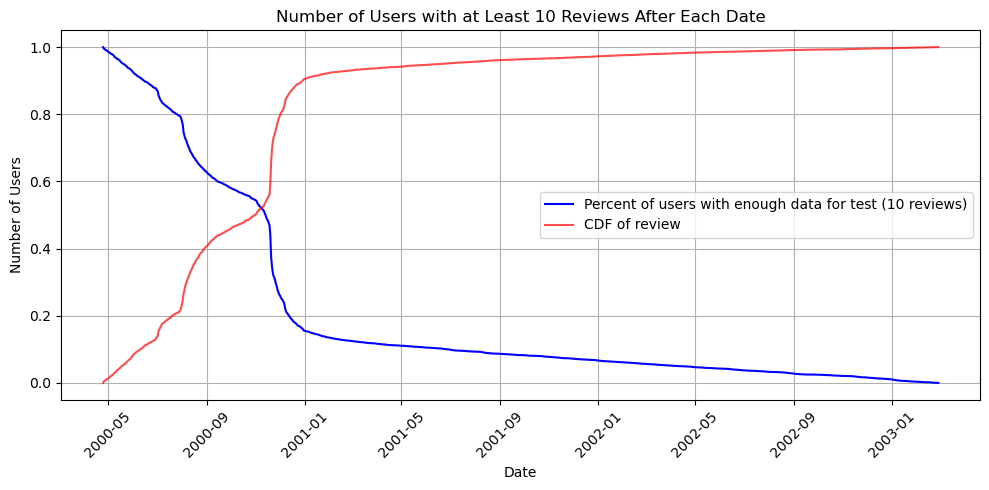

In [100]:
results = {}
unique_dates = df_ratings['Date'].sort_values().unique()

for date in unique_dates:
    df_future = df_ratings[df_ratings['Date'] > date]
    user_review_counts = df_future.groupby('UserID').size()
    users_with_at_least_10_reviews = user_review_counts[user_review_counts >= 10].count()
    results[pd.to_datetime(date)] = users_with_at_least_10_reviews / df_users.shape[0]

plt.figure(figsize=(10, 5))
plt.plot(list(results.keys()), list(results.values()), color='blue', label="Percent of users with enough data for test (10 reviews)")
plt.title('Number of Users with at Least 10 Reviews After Each Date')
plt.xlabel('Date')
plt.ylabel('Number of Users')
cumsum = df_ratings["Date"].value_counts().sort_index().cumsum()
cumsum = cumsum / cumsum.max()
plt.plot(cumsum.index, cumsum.values, color='red', alpha=0.7, label="CDF of review")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [137]:
date_to_split = cumsum[cumsum >= 0.8].index[0] # 80% train; 20% test
print(date_to_split)

2000-12-02 00:00:00


Users in train:

In [162]:
print("Number of unique users:")
len(df_ratings[df_ratings["Date"]<date_to_split]["UserID"].unique())

Number of unique users:


5390

In [163]:
print("Average number of reviews by user:")
round(df_ratings[df_ratings["Date"]<date_to_split].groupby(["UserID"]).count().mean()["Rating"], 2)

Average number of reviews by user:


147.89

Users in test:

In [164]:
print("Number of unique users:")
len(df_ratings[df_ratings["Date"]>=date_to_split]["UserID"].unique())

Number of unique users:


1802

In [165]:
print("Average number of reviews by user:")
round(df_ratings[df_ratings["Date"]>=date_to_split].groupby(["UserID"]).count().mean()["Rating"], 2)

Average number of reviews by user:


112.7

### Conclusions